# Loading the Libraries 📚

In [ ]:
!pip install tensorflow pandas matplotlib

# Mounting the drive in workspace ⚓

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Libraries needed 🤌

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam




# Loading the datasets from drive 💽

In [ ]:
# Path to the dataset in Google Drive
dataset_path = '/content/drive/MyDrive/DeepFashion-MultiModal'

# Define paths
images_path = os.path.join(dataset_path, 'images')
parsing_path = os.path.join(dataset_path, 'segm')
densepose_path = os.path.join(dataset_path, 'densePose')
keypoints_loc_path = os.path.join(dataset_path, 'keypoints', 'keypoints_loc.txt')
keypoints_vis_path = os.path.join(dataset_path, 'keypoints', 'keypoints_vis.txt')
shape_labels_path = os.path.join(dataset_path, 'labels', 'shape', 'shape_anno_all.txt')
fabric_labels_path = os.path.join(dataset_path, 'labels', 'texture', 'fabric_ann.txt')
pattern_labels_path = os.path.join(dataset_path, 'labels', 'texture', 'pattern_ann.txt')
textual_desc_path = os.path.join(dataset_path, 'captions.json')



In [ ]:
# Load the shape labels
shape_labels = pd.read_csv(shape_labels_path, delimiter=' ', header=None)
shape_labels.columns = ['image'] + [f'shape_{i}' for i in range(12)]

# Load the fabric labels
fabric_labels = pd.read_csv(fabric_labels_path, delimiter=' ', header=None)
fabric_labels.columns = ['image', 'upper_fabric', 'lower_fabric', 'outer_fabric']

# Load the color labels
pattern_labels = pd.read_csv(pattern_labels_path, delimiter=' ', header=None)
pattern_labels.columns = ['image', 'upper_color', 'lower_color', 'outer_color']


In [ ]:
shape_labels.head()

,image,shape_0,shape_1,shape_2,shape_3,shape_4,shape_5,shape_6,shape_7,shape_8,shape_9,shape_10,shape_11
0,MEN-Denim-id_00000080-01_7_additional.jpg,5,3,0,0,0,0,0,0,3,2,1,1
1,MEN-Denim-id_00000089-01_7_additional.jpg,0,3,0,0,0,0,0,0,3,2,1,1
2,MEN-Denim-id_00000089-02_7_additional.jpg,3,3,0,0,0,0,0,0,3,4,1,1
3,MEN-Denim-id_00000089-03_7_additional.jpg,1,3,0,0,0,0,0,0,3,2,1,1
4,MEN-Denim-id_00000089-04_7_additional.jpg,3,3,0,0,0,0,0,0,3,4,1,1


In [ ]:
# Merge the labels into a single dataframe
labels = shape_labels.merge(fabric_labels, on='image').merge(pattern_labels, on='image')

In [ ]:
labels.head()

,image,shape_0,shape_1,shape_2,shape_3,shape_4,shape_5,shape_6,shape_7,shape_8,shape_9,shape_10,shape_11,upper_fabric,lower_fabric,outer_fabric,upper_color,lower_color,outer_color
0,MEN-Denim-id_00000080-01_7_additional.jpg,5,3,0,0,0,0,0,0,3,2,1,1,1,1,7,3,4,7
1,MEN-Denim-id_00000089-01_7_additional.jpg,0,3,0,0,0,0,0,0,3,2,1,1,1,1,7,3,3,7
2,MEN-Denim-id_00000089-02_7_additional.jpg,3,3,0,0,0,0,0,0,3,4,1,1,1,1,7,2,3,7
3,MEN-Denim-id_00000089-03_7_additional.jpg,1,3,0,0,0,0,0,0,3,2,1,1,1,1,7,3,3,7
4,MEN-Denim-id_00000089-04_7_additional.jpg,3,3,0,0,0,0,0,0,3,4,1,1,0,1,7,3,3,7


In [ ]:
# Add image paths to the dataframe
labels['image_path'] = labels['image'].apply(lambda x: os.path.join(images_path, x))
labels.shape

(42544, 20)

#Loading only image data without missing values

In [ ]:
# Get a list of all image files in the images directory
existing_images = set(os.listdir(images_path))

# Check if image files listed in the labels exist
def file_exists(file_path):
    return os.path.basename(file_path) in existing_images

labels['file_exists'] = labels['image_path'].apply(file_exists)

# Filter out entries with missing images
valid_labels = labels[labels['file_exists']].drop(columns=['file_exists'])


In [ ]:
valid_labels.shape

(21082, 20)

In [ ]:
valid_labels.head()

,image,shape_0,shape_1,shape_2,shape_3,shape_4,shape_5,shape_6,shape_7,shape_8,shape_9,shape_10,shape_11,upper_fabric,lower_fabric,outer_fabric,upper_color,lower_color,outer_color,image_path
0,MEN-Denim-id_00000080-01_7_additional.jpg,5,3,0,0,0,0,0,0,3,2,1,1,1,1,7,3,4,7,/content/drive/MyDrive/DeepFashion-MultiModal/...
1,MEN-Denim-id_00000089-01_7_additional.jpg,0,3,0,0,0,0,0,0,3,2,1,1,1,1,7,3,3,7,/content/drive/MyDrive/DeepFashion-MultiModal/...
2,MEN-Denim-id_00000089-02_7_additional.jpg,3,3,0,0,0,0,0,0,3,4,1,1,1,1,7,2,3,7,/content/drive/MyDrive/DeepFashion-MultiModal/...
3,MEN-Denim-id_00000089-03_7_additional.jpg,1,3,0,0,0,0,0,0,3,2,1,1,1,1,7,3,3,7,/content/drive/MyDrive/DeepFashion-MultiModal/...
4,MEN-Denim-id_00000089-04_7_additional.jpg,3,3,0,0,0,0,0,0,3,4,1,1,0,1,7,3,3,7,/content/drive/MyDrive/DeepFashion-MultiModal/...


# Checking how many unique values are there in labels

In [ ]:
print("Unique values for shape_0:", valid_labels['shape_0'].unique())
print("Unique values for upper_fabric:", valid_labels['upper_fabric'].unique())
print("Unique values for upper_color:", valid_labels['upper_color'].unique())


Unique values for shape_0: [5 0 3 1 2 4]
Unique values for upper_fabric: [1 0 7 4 2 6 5 3]
Unique values for upper_color: [3 2 4 7 5 1 6 0]


# Defining the Model

In [ ]:
# Sample the valid dataset
def random_sampling(df, sampling_ratio=0.1):
    return df.sample(frac=sampling_ratio).reset_index(drop=True)

sampled_df = random_sampling(valid_labels, sampling_ratio=0.1)

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size, img_size, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y_shape, y_fabric, y_color = self.__data_generation(batch_df)
        return X, {'shape_output': y_shape, 'fabric_output': y_fabric, 'color_output': y_color}

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, batch_df):
      X_img = np.empty((self.batch_size, *self.img_size, 3), dtype=np.float32)
      y_shape = np.empty((self.batch_size,), dtype=np.int32)
      y_fabric = np.empty((self.batch_size,), dtype=np.int32)
      y_color = np.empty((self.batch_size,), dtype=np.int32)

      for i, (_, row) in enumerate(batch_df.iterrows()):
          try:
              # Load and preprocess image
              img = tf.keras.preprocessing.image.load_img(row['image_path'], target_size=self.img_size)
              img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
              X_img[i,] = img_array

              # Load labels
              y_shape[i] = row['shape_0']
              y_fabric[i] = row['upper_fabric']
              y_color[i] = row['upper_color']
          except Exception as e:
              print(f"Error loading image {row['image_path']}: {e}")

      return X_img, y_shape, y_fabric, y_color


# Define parameters
batch_size = 32
img_size = (224, 224)

# Initialize data generator
train_generator = CustomDataGenerator(sampled_df, batch_size, img_size, shuffle=True)

# Build the model
def create_model(img_size):
    input_img = layers.Input(shape=(*img_size, 3))

    # Feature extractor
    x = layers.Conv2D(32, (3, 3), activation='relu')(input_img)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output layers
    shape_output = layers.Dense(6, activation='softmax', name='shape_output')(x)  # Updated to 6 classes
    fabric_output = layers.Dense(8, activation='softmax', name='fabric_output')(x)  # Updated to 8 classes
    color_output = layers.Dense(8, activation='softmax', name='color_output')(x)  # Updated to 8 classes

    # Define the model
    model = models.Model(inputs=input_img, outputs={'shape_output': shape_output, 'fabric_output': fabric_output, 'color_output': color_output})

    return model



model = create_model(img_size)

# Compile the model
model.compile(
    optimizer='adam',
    loss={'shape_output': 'sparse_categorical_crossentropy',
          'fabric_output': 'sparse_categorical_crossentropy',
          'color_output': 'sparse_categorical_crossentropy'},
    metrics={'shape_output': 'accuracy',
             'fabric_output': 'accuracy',
             'color_output': 'accuracy'}
)

# Train the model
model.fit(
    train_generator,
    epochs=10
)


Epoch 1/10
65/65 [==============================] - 719s 11s/step - loss: 4.0937 - color_output_loss: 1.6321 - fabric_output_loss: 0.9952 - shape_output_loss: 1.4665 - color_output_accuracy: 0.4870 - fabric_output_accuracy: 0.6933 - shape_output_accuracy: 0.4187
Epoch 2/10
65/65 [==============================] - 298s 5s/step - loss: 3.3871 - color_output_loss: 1.3065 - fabric_output_loss: 0.8392 - shape_output_loss: 1.2413 - color_output_accuracy: 0.5625 - fabric_output_accuracy: 0.7188 - shape_output_accuracy: 0.4630
Epoch 3/10
65/65 [==============================] - 298s 5s/step - loss: 3.1189 - color_output_loss: 1.1922 - fabric_output_loss: 0.7924 - shape_output_loss: 1.1343 - color_output_accuracy: 0.5928 - fabric_output_accuracy: 0.7255 - shape_output_accuracy: 0.5370
Epoch 4/10
65/65 [==============================] - 298s 5s/step - loss: 2.8061 - color_output_loss: 1.0972 - fabric_output_loss: 0.7385 - shape_output_loss: 0.9705 - color_output_accuracy: 0.6236 - fabric_output_

# Predicting the Clothes attributes using random image input of clothes 👚

The model is initially saved in drive so that it can later be used


In [ ]:
# Save the entire model
model.save('/content/drive/MyDrive/DeepFashion-MultiModal/model.h5')

# Alternatively, save only the model weights
model.save_weights('/content/drive/MyDrive/DeepFashion-MultiModal/model_weights.h5')



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## loading the saved model in drive

In [ ]:
from tensorflow.keras.models import load_model

# Load the entire model
model = load_model('/content/drive/MyDrive/DeepFashion-MultiModal/model.h5')




## using the model to predict clothes shape fabric and color 🎨

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(image_path, img_size):
    # Load and resize the image
    img = image.load_img(image_path, target_size=img_size)

    # Convert the image to a numpy array and normalize pixel values
    img_array = image.img_to_array(img) / 255.0

    # Expand dimensions to match the model's input shape (batch_size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array


1/1 [==============================] - 0s 53ms/step
Predicted Shape: Sleveless
Predicted Fabric: Chiffron
Predicted Color: graphic


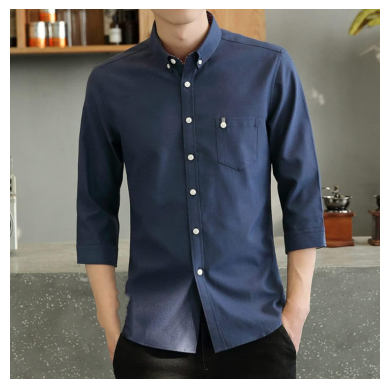

In [ ]:
# Define image path and size
image_path = '/content/drive/MyDrive/DeepFashion-MultiModal/sleeve.jpg'
img_size = (224, 224)

# Preprocess and predict
img_array = preprocess_image(image_path, img_size)
predictions = model.predict(img_array)

# Decode predictions
shape_pred = np.argmax(predictions['shape_output'], axis=-1)
fabric_pred = np.argmax(predictions['fabric_output'], axis=-1)
color_pred = np.argmax(predictions['color_output'], axis=-1)

# Example mappings
shape_labels = {0: 'Sleveless', 1: 'Short sleeve', 2: 'medium sleeve', 3: 'long-sleeve', 4: 'not long sleeve', 5: 'NA'}
fabric_labels = {0: 'denim', 1: 'Cotton', 2: 'Leather', 3: 'furry', 4: 'Knitted', 5: 'Chiffron', 6: 'other', 7: 'NA'}
color_labels = {0: 'floral', 1: 'graphic', 2: 'Stripped', 3: 'pure color', 4: 'lattice', 5: 'Other', 6: 'color block', 7: 'NA'}

# Decode and print predictions
shape_label = shape_labels[shape_pred[0]]
fabric_label = fabric_labels[fabric_pred[0]]
color_label = color_labels[color_pred[0]]

print(f"Predicted Shape: {shape_label}")
print(f"Predicted Fabric: {fabric_label}")
print(f"Predicted Color: {color_label}")

# Display the image
img = image.load_img(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# Function to create a small subset of the dataset
def create_small_subset(df, subset_size):
    return df.sample(n=subset_size).reset_index(drop=True)

# Create a small subset of valid_labels
small_subset_df = create_small_subset(valid_labels, subset_size=100)  # You can adjust the size as needed

# Initialize data generator with the small subset
small_train_generator = CustomDataGenerator(small_subset_df, batch_size, img_size, shuffle=False)

# Compile the model (ensure it is compiled before evaluation)
model.compile(
    optimizer='adam',
    loss={'shape_output': 'sparse_categorical_crossentropy',
          'fabric_output': 'sparse_categorical_crossentropy',
          'color_output': 'sparse_categorical_crossentropy'},
    metrics={'shape_output': 'accuracy',
             'fabric_output': 'accuracy',
             'color_output': 'accuracy'}
)

# Evaluate the model on the small subset
train_loss, shape_loss, fabric_loss, color_loss, shape_acc, fabric_acc, color_acc = model.evaluate(small_train_generator)

print(f"Training Loss: {train_loss}")
print(f"Shape Output Loss: {shape_loss}, Accuracy: {shape_acc}")
print(f"Fabric Output Loss: {fabric_loss}, Accuracy: {fabric_acc}")
print(f"Color Output Loss: {color_loss}, Accuracy: {color_acc}")


3/3 [==============================] - 19s 9s/step - loss: 3.0476 - color_output_loss: 1.4394 - fabric_output_loss: 0.8765 - shape_output_loss: 0.7317 - color_output_accuracy: 0.6042 - fabric_output_accuracy: 0.7500 - shape_output_accuracy: 0.7083
Training Loss: 3.047560453414917
Shape Output Loss: 1.439351201057434, Accuracy: 0.6041666865348816
Fabric Output Loss: 0.8764980435371399, Accuracy: 0.75
Color Output Loss: 0.731711208820343, Accuracy: 0.7083333134651184


# From the clothes we can conclude it is _____ and in colcusion this project shows how to train model without using transfer learning and multiple labels.

# **Thankyou**

